### Workspace for quick operations, independent of page behavior ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from hexatable import hexa_table, hexa_table_frag, hexa_frag_cost, hex_frag_multiplier, hexa_prob
from hexa_strategy import HexaStrategyModel

np.set_printoptions(precision=4, suppress=True)

In [2]:
max_level = 10  # 총 단계 수
max_attempts = 20  # 최대 시도 횟수

def reinforce(table, x, num_reinforcements, do_compress=True):
    init = table.create_vector(x)
    result = init @ np.linalg.matrix_power(
        table.get_matrix(),
        num_reinforcements
    )
    if do_compress:
        return table.compress_state_dict(table.vector_to_state_dict(result), [0])
    else:
        return result


def steady_state_distribution(M):
    pi = np.linalg.matrix_power(M, 1 << 64)
    return pi


def matrix_semi_inf_geometric_series(M):
    I = np.eye(M.shape[0])

    Q = steady_state_distribution(M)
    Z = M - Q

    inv_matrix = np.linalg.inv(I - Z)
    
    return inv_matrix 


def matrix_power_series(M, n):
    I = np.eye(M.shape[0])

    Q = steady_state_distribution(M)
    Z = M - Q

    Z_powered = np.linalg.matrix_power(Z, n+1)
    inv_matrix = np.linalg.inv(I - Z)
    
    return (I - Z_powered) @ inv_matrix + n*Q
    

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


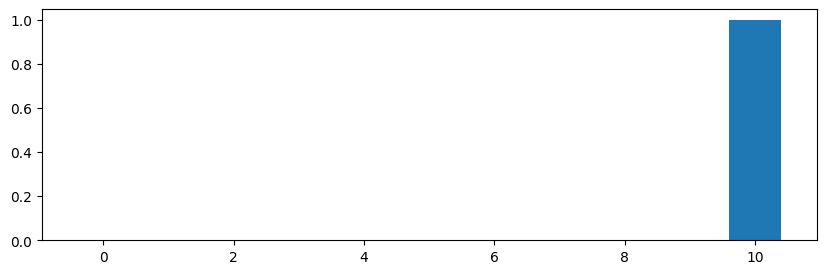

10255.904926029763
145148.1935928751


In [3]:
goal_level = 1 # 목표 레벨
high_value_preference = False

frag_meso = 0.07
init_meso = 0.1

is_sunday = False

hsm = HexaStrategyModel(goal_level, hexa_frag_cost, hexa_prob[is_sunday], frag_meso, init_meso, max_level, max_attempts, high_value_preference=high_value_preference)


num_reinforcements = 1 << 64
x = {(0, 0): 1} # main-level, attempts

######## Apply Strategy ########

table = hexa_table[is_sunday]
strategy_table = copy.deepcopy(table)


for m in range(max_level+1):
    for t in range(max_attempts+1):
        if hsm.should_stop[m][t]:
            strategy_table.clear_transition((m, t))
            strategy_table.add_transition((m, t), (0, 0), 1.0)


if high_value_preference:
    for level in range(goal_level, max_level+1):
        strategy_table.clear_transition((level, max_attempts))
        strategy_table.add_transition((level, max_attempts), (level, max_attempts), 1.0)
else:
    for level in range(0, goal_level+1):
        strategy_table.clear_transition((level, max_attempts))
        strategy_table.add_transition((level, max_attempts), (level, max_attempts), 1.0)

strategy_table.compile()
print(np.sum(strategy_table.get_matrix(), axis=1))

######## Do Reinforce ########

result = reinforce(strategy_table, x, num_reinforcements)

result_vector = np.zeros(max_level+1)
for i in range(max_level+1):
    result_vector[i] = result[(i,)]


######## Log & Visualize ########

print(result_vector)
plt.figure(figsize=(10, 3))
plt.bar(range(len(result_vector)), result_vector)
plt.show()


def cost_branch(state, hsm, only_frag=False):
    i, j = state
    if hsm.should_stop[i][j]:
        return init_meso if not only_frag else 0
    elif j == 20:
        return 0
    else:
        return hexa_frag_cost[i] * hex_frag_multiplier * frag_meso if not only_frag else hexa_frag_cost[i] * hex_frag_multiplier


strategy_cost = strategy_table.create_vector({
    (i, j) : cost_branch((i, j), hsm) for i, j in strategy_table.states
})

strategy_frag_cost = strategy_table.create_vector({
    (i, j) : cost_branch((i, j), hsm, True) for i, j in strategy_table.states
})

xvector = strategy_table.create_vector(x)
migs = matrix_semi_inf_geometric_series(strategy_table.get_matrix())

expected_cost = xvector @ migs @ strategy_cost.T
expected_frag_cost = xvector @ migs @ strategy_frag_cost.T

print(expected_cost)
print(expected_frag_cost)

(363, 363)
[0.013  0.1397 0.     0.     0.     0.     0.     0.     0.     0.
 0.    ]


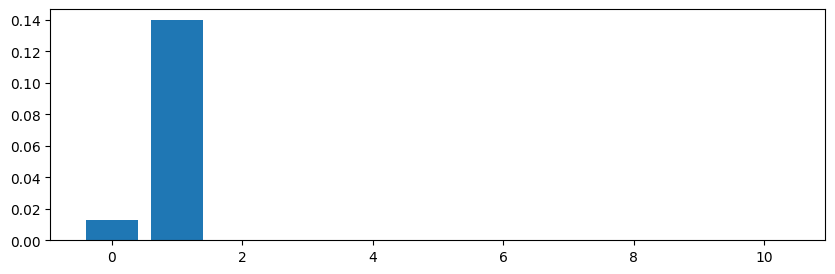

0.012970738062682478
0.1526556058472336


In [13]:
goal_level = 1 # 목표 레벨
high_value_preference = False

frag_meso = 0.07
init_meso = 0.1

is_sunday = False

hsm = HexaStrategyModel(goal_level, hexa_frag_cost, hexa_prob[is_sunday], frag_meso, init_meso, max_level, max_attempts, high_value_preference=high_value_preference)


num_frags = 10000
x = {(0, 0, 0): 1} # main-level, attempts, spent-frags

######## Apply Strategy ########

table = hexa_table_frag[is_sunday]
strategy_table = copy.deepcopy(table)


init_states = []
for fsstate, prob in strategy_table.transitions.items():
    from_state, to_state = fsstate
    m, t, f = to_state
    if hsm.should_stop[m][t] and f == 0:
        init_states.append((from_state, to_state, prob))

for from_state, to_state, prob in init_states:
    del strategy_table.transitions[(from_state, to_state)]
    prev_prob = strategy_table.transitions.get((from_state, (0, 0, 0)), 0)
    strategy_table.add_transition(from_state, (0, 0, 0), prev_prob + prob)


if high_value_preference:
    for level in range(goal_level, max_level+1):
        strategy_table.clear_transition((level, max_attempts, 0))
        strategy_table.add_transition((level, max_attempts, 0), (level, max_attempts, 0), 1.0)   
else:
    for level in range(0, goal_level+1):
        strategy_table.clear_transition((level, max_attempts, 0))
        strategy_table.add_transition((level, max_attempts, 0), (level, max_attempts, 0), 1.0)

strategy_table.compile()
print(strategy_table.get_matrix().shape)

result_vector = np.zeros(max_level+1)

######## Do Reinforce ########
if high_value_preference:
    result = reinforce(strategy_table, x, num_frags // hex_frag_multiplier)

    for i in range(max_level+1):
        result_vector[i] = result[(i,)]

else:
    result = reinforce(strategy_table, x, num_frags // hex_frag_multiplier, False)
    result = strategy_table.compress_state_dict(strategy_table.vector_to_state_dict(result), [0, 1])
    for i in range(max_level+1):
        result_vector[i] = result.get((i,max_attempts), 0)

######## Log & Visualize ########

print(result_vector)
plt.figure(figsize=(10, 3))
plt.bar(range(len(result_vector)), result_vector)
plt.show()

if high_value_preference:
    print(np.sum(result_vector[goal_level:]))
else:
    print(np.sum(result_vector[:goal_level]))

print(np.sum(result_vector))

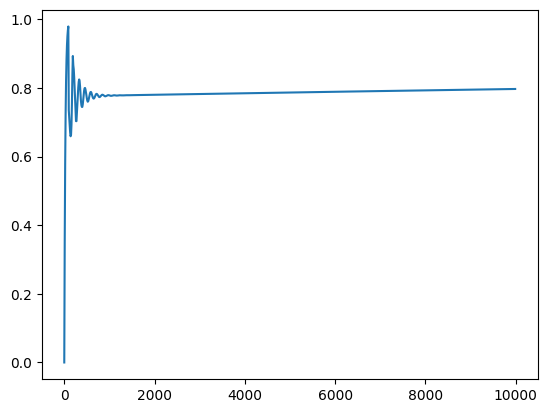

In [ ]:
x = {(0, 0, 0): 1}
y = {}

for state in strategy_table.states:
    m, t, f = state
    if m >= goal_level:
        y[state] = 1

init = strategy_table.create_vector(x)
goal_filter = strategy_table.create_vector(y)

M = strategy_table.get_matrix()
M_powered = np.eye(M.shape[0])

N = 1000
cdf = np.zeros(N)

for n in range(0, N):
    cdf[n] = init @ M_powered @ goal_filter
    M_powered = M_powered @ M

plt.plot(np.arange(0, hex_frag_multiplier*N, hex_frag_multiplier), cdf)
plt.show()
